# <center> AFG Oberseminar: Tomographic Reconstruction and Wavefront Set <center>
### <center> Héctor Andrade Loarca </center>
#### <center> 31st May 2018 </center>
<img src="./tub-afg.jpg" alt="Mountain View" style="width:250px;">

In [157]:
import warnings
warnings.filterwarnings('ignore')

In [158]:
import odl
import scipy
import numpy as np

In [159]:
import matplotlib.pyplot as plt
%matplotlib inline

## Reconstruction on the image

### Define geometry, operators and data

In [160]:
# Create ODL data structures
size = 128
space = odl.uniform_discr([-64, -64], [64, 64], [size, size],
                          dtype='float64')

In [161]:
# Using as backend scikit-image
geometry = odl.tomo.parallel_beam_geometry(space, num_angles=30)
operator = odl.tomo.RayTransform(space, geometry)

In [162]:
# Ensure operator has fixed operator norm for scale invariance
opnorm = odl.power_method_opnorm(operator)
operator = (1 / opnorm) * operator

In [163]:
# Assemble all operators into a list.
grad = odl.Gradient(space)
lin_ops = [operator, grad]
a = 0.001

In [164]:
phantom = odl.phantom.shepp_logan(space, True)

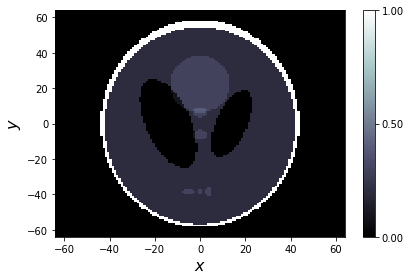

<Figure size 432x288 with 0 Axes>

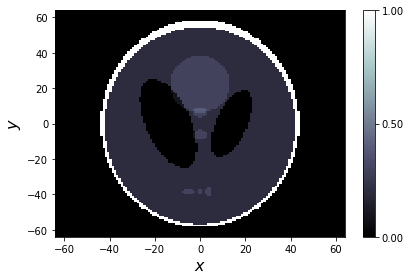

In [165]:
phantom.show()

In [166]:
g = operator(phantom)

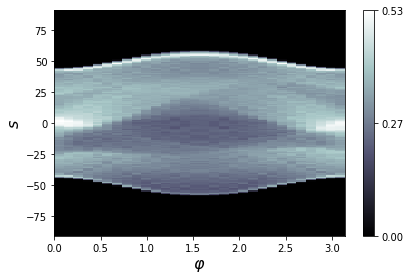

<Figure size 432x288 with 0 Axes>

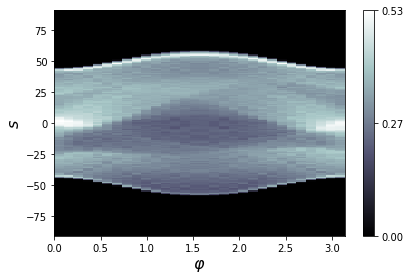

In [167]:
g.show()

## Tikhonov regularization

In [168]:
# Tikhonov with gradient
B = odl.Gradient(space)
a = 0.0001
T =  operator.adjoint * operator + a * B.adjoint * B
b = operator.adjoint(g)

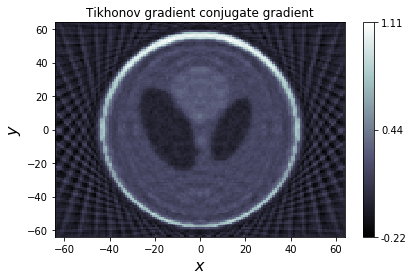

<Figure size 432x288 with 0 Axes>

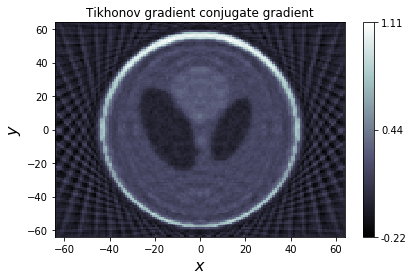

In [169]:
f = space.zero()
odl.solvers.conjugate_gradient(T, f, b, niter=500)
f.show('Tikhonov gradient conjugate gradient')

## TV Reconstruction

In [170]:
# Create functionals for the l2 distance and l1 norm.
g_funcs = [odl.solvers.L2NormSquared(operator.range).translated(g),
           a * odl.solvers.L1Norm(grad.range)]

In [171]:
# Functional of the bound constraint 0 <= x <= 1
f = odl.solvers.IndicatorBox(space, 0, 1)

In [172]:
# Find scaling constants so that the solver converges.
# See the douglas_rachford_pd documentation for more information.
opnorm = odl.power_method_opnorm(operator)
opnorm_grad = odl.power_method_opnorm(grad)

In [173]:
sigma = [1 / opnorm ** 2, 1 / opnorm_grad ** 2]
tau = 1.0

# Solve using the Douglas-Rachford Primal-Dual method
x = space.zero()

In [174]:
odl.solvers.douglas_rachford_pd(x, f, g_funcs, lin_ops,
                                tau=tau, sigma=sigma, niter=500)

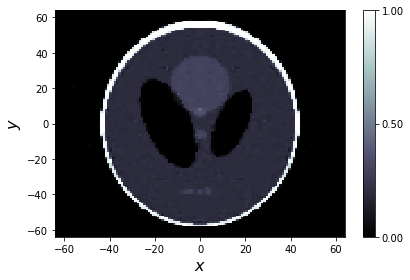

<Figure size 432x288 with 0 Axes>

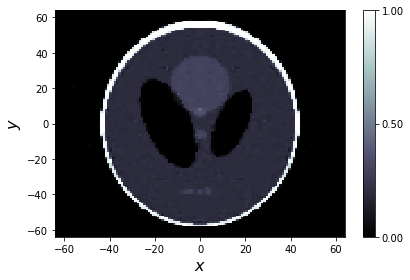

In [175]:
x.show()

## Reconstruction on the shearlet coefficients

In [222]:
import odl 

In [223]:
# Create ODL data structures
size = 128
space_image = odl.uniform_discr([-64, -64], [64, 64], [size, size],
                          dtype='float64')

In [224]:
import odl.contrib.shearlab

**Shearlet analysis and synthesis operator**

In [225]:
# Shearing analysis operator
shearan= odl.contrib.shearlab.ShearlabOperator(space_image,num_scales= 4)

In [226]:
# Shearlet synthesis operator
shearsyn = shearan.inverse

In [227]:
# Shearlet coefficietns space
space = shearsyn.domain

**Ray operator**

In [228]:
# Using as backend scikit-image
geometry = odl.tomo.parallel_beam_geometry(shearsyn.range, num_angles=30)
ray_operator= odl.tomo.RayTransform(shearsyn.range, geometry)

**Operator = Ray(Shearsyn)**

In [229]:
operator = odl.operator.operator.OperatorComp(ray_operator,shearsyn)

In [230]:
# Ensure operator has fixed operator norm for scale invariance
opnorm = odl.power_method_opnorm(operator)
operator = (1 / opnorm) * operator

**Data and phantom**

In [231]:
phantom = shearan(odl.phantom.shepp_logan(space_image, True))

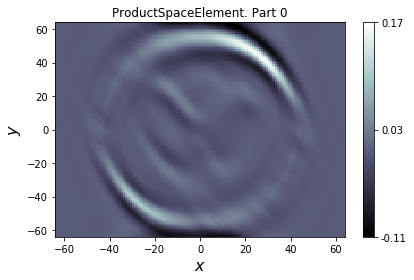

<Figure size 432x288 with 0 Axes>

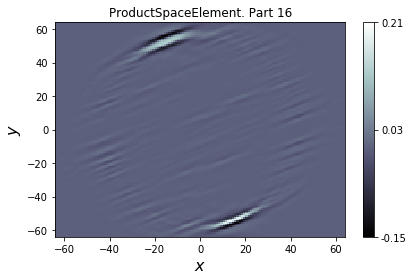

<Figure size 432x288 with 0 Axes>

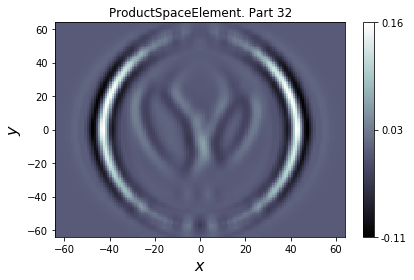

<Figure size 432x288 with 0 Axes>

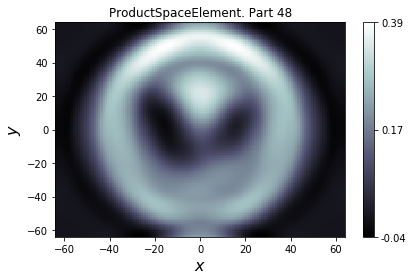

<Figure size 432x288 with 0 Axes>

(<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>)

In [232]:
phantom.show()

In [233]:
g = operator(phantom)

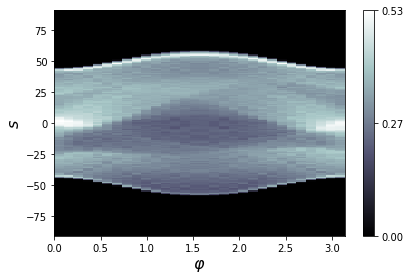

<Figure size 432x288 with 0 Axes>

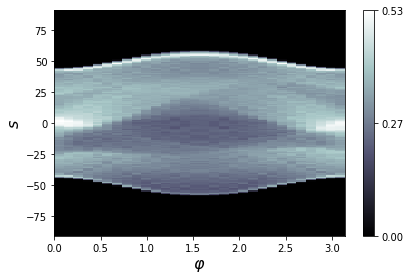

In [234]:
g.show()

### Tikhonov regularization

Initial shearlet coefficientes

In [235]:
# Tikhonov with gradient
B = odl.DiagonalOperator(odl.Gradient(space[0]), 49)
a = 0.0001
T =  operator.adjoint * operator + a * B.adjoint * B
b = operator.adjoint(g)

In [236]:
# Tikhonov with gradient
B = odl.operator.operator.OperatorComp(odl.Gradient(space_image),shearsyn)
a = 0.0001
T =  operator.adjoint * operator + a * B.adjoint * B
b = operator.adjoint(g)

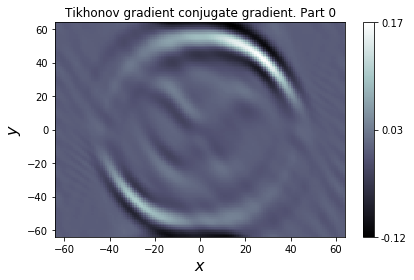

<Figure size 432x288 with 0 Axes>

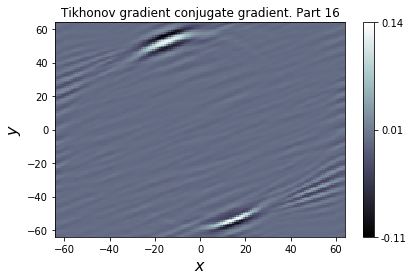

<Figure size 432x288 with 0 Axes>

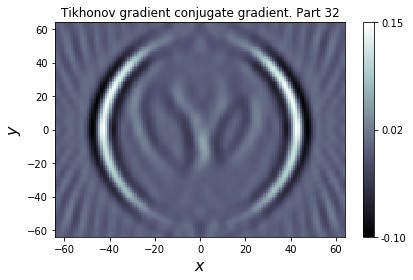

<Figure size 432x288 with 0 Axes>

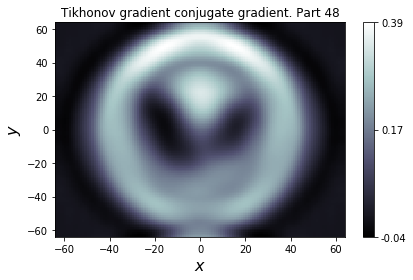

<Figure size 432x288 with 0 Axes>

(<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>)

In [237]:
f = space.zero()
odl.solvers.conjugate_gradient(T, f, b, niter=100)
f.show('Tikhonov gradient conjugate gradient')

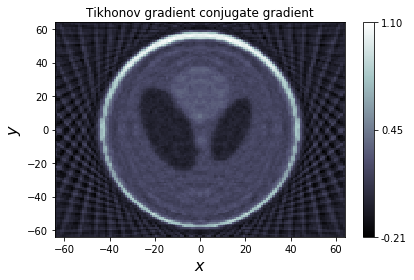

<Figure size 432x288 with 0 Axes>

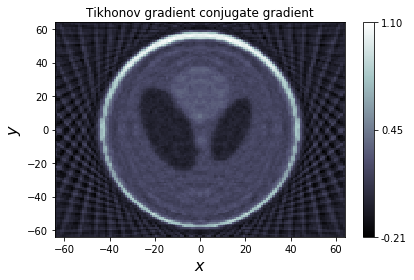

In [238]:
shearsyn(f).show('Tikhonov gradient conjugate gradient')

### TV regularization

In [239]:
# Assemble all operators into a list.
grad = odl.DiagonalOperator(odl.Gradient(space[0]), 49)
lin_ops = [operator, grad]
a = 0.001

In [240]:
# Create functionals for the l2 distance and l1 norm.
g_funcs = [odl.solvers.L2NormSquared(operator.range).translated(g),
           a * odl.solvers.L1Norm(grad.range)]

In [244]:
grad = odl.operator.operator.OperatorComp(odl.Gradient(space_image),shearsyn)
lin_ops = [operator, grad]
a = 0.001

In [246]:
# Create functionals for the l2 distance and l1 norm.
g_funcs = [odl.solvers.L2NormSquared(operator.range).translated(g),
           a * odl.solvers.L1Norm(grad.range)]

In [247]:
# Functional of the bound constraint 0 <= x <= 1
f = odl.solvers.IndicatorBox(space, 0, 1)

In [248]:
# Find scaling constants so that the solver converges.
# See the douglas_rachford_pd documentation for more information.
opnorm = odl.power_method_opnorm(operator)

In [249]:
opnorm_grad = odl.power_method_opnorm(grad)

In [250]:
sigma = [1 / opnorm ** 2, 1 / opnorm_grad ** 2]
tau = 1.0

# Solve using the Douglas-Rachford Primal-Dual method
x = space.zero()

In [251]:
odl.solvers.douglas_rachford_pd(x, f, g_funcs, lin_ops,
                                tau=tau, sigma=sigma, niter=500)

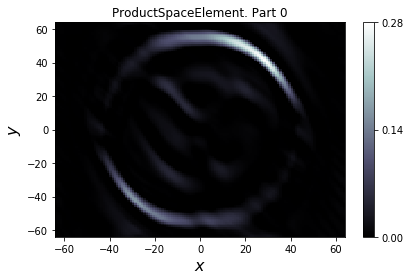

<Figure size 432x288 with 0 Axes>

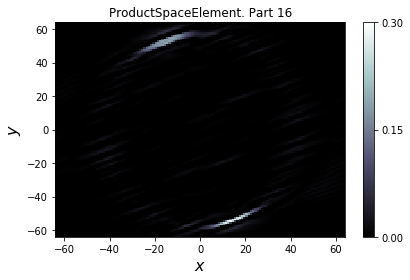

<Figure size 432x288 with 0 Axes>

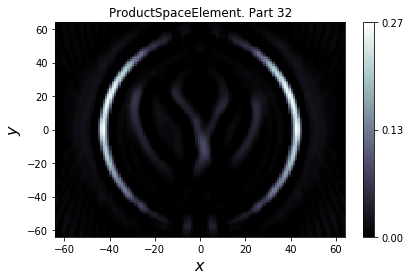

<Figure size 432x288 with 0 Axes>

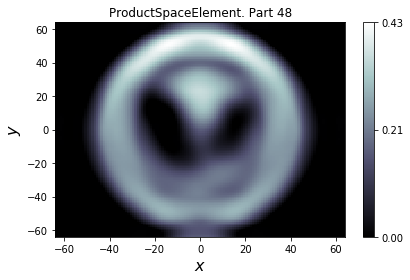

<Figure size 432x288 with 0 Axes>

(<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>)

In [252]:
x.show()

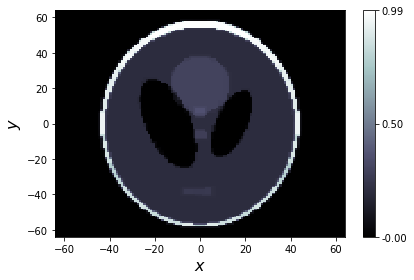

<Figure size 432x288 with 0 Axes>

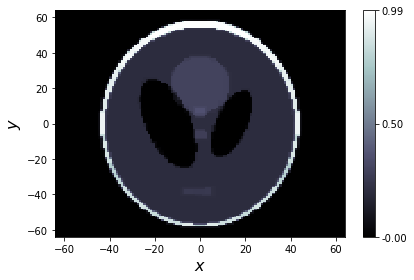

In [253]:
shearsyn(x).show()